C:\Users\Sam\AppData\Local\Temp\ipykernel_23852\2842013715.py:37: RuntimeWarning: divide by zero encountered in log10
  plt.pcolor(X, Y, np.log10(C), shading = 'auto',vmin=5)


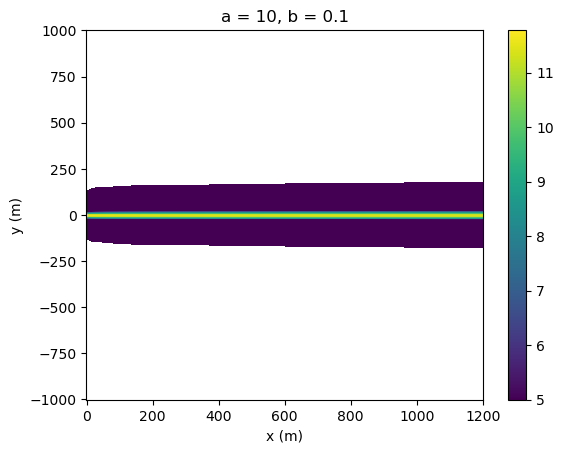

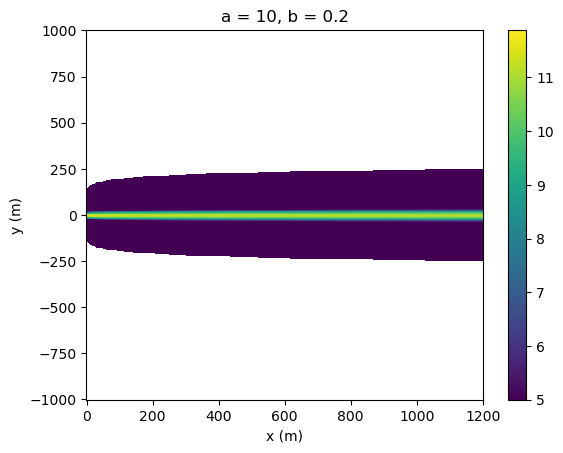

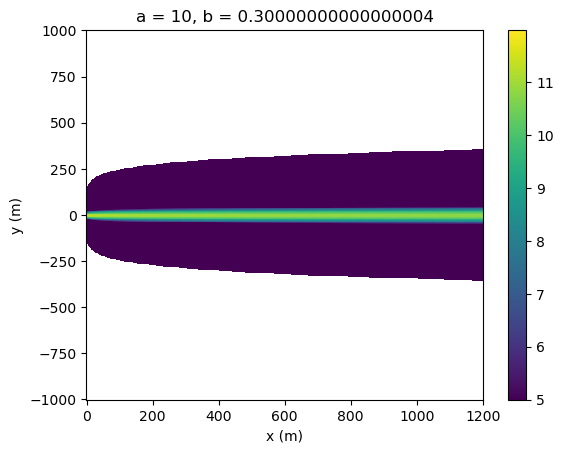

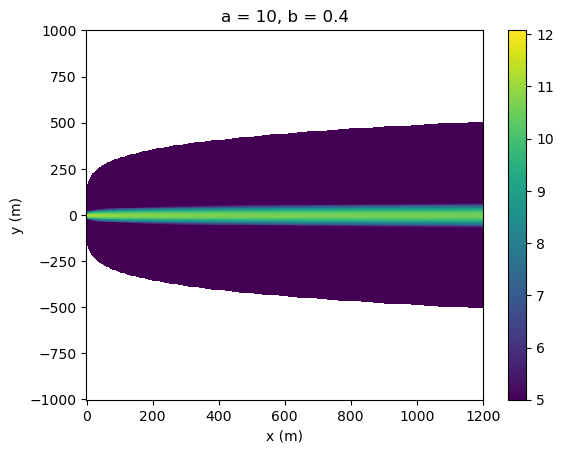

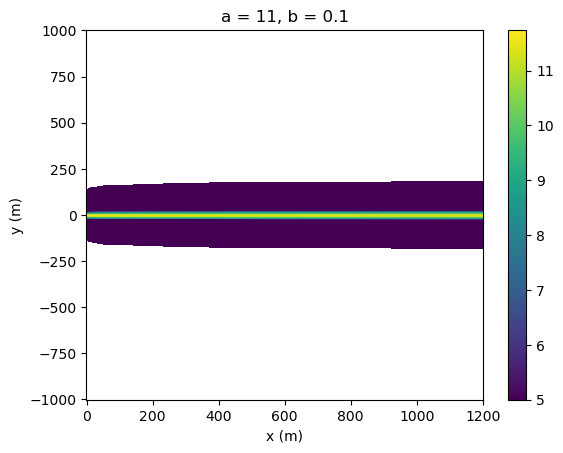

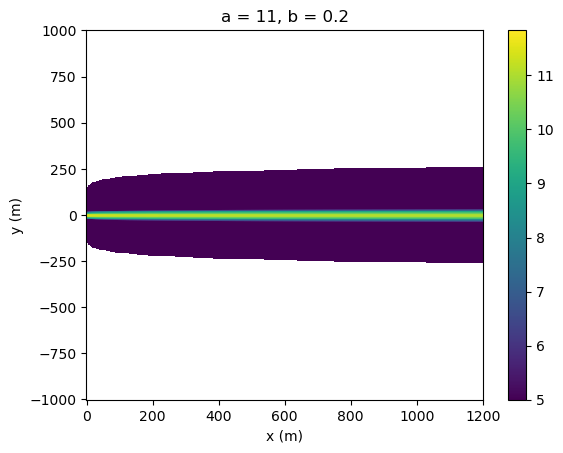

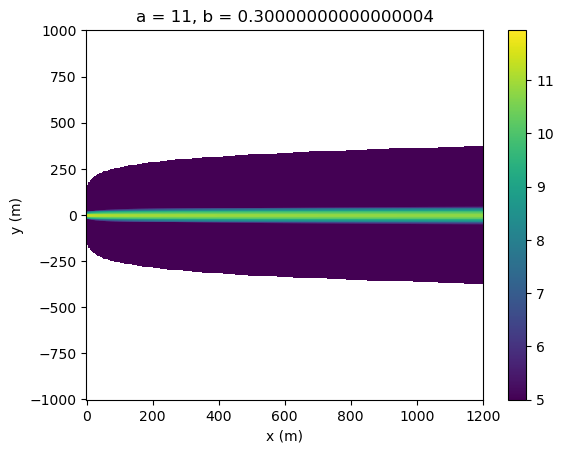

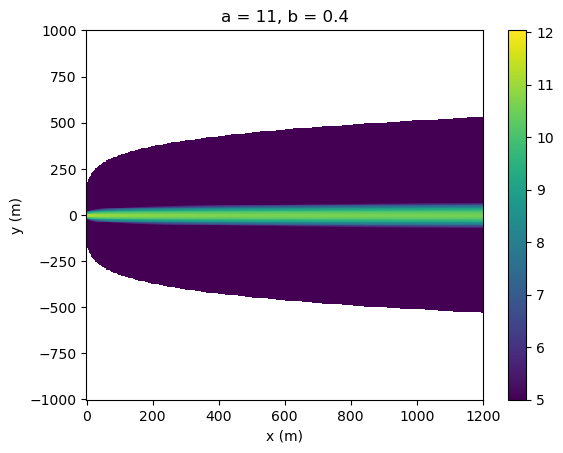

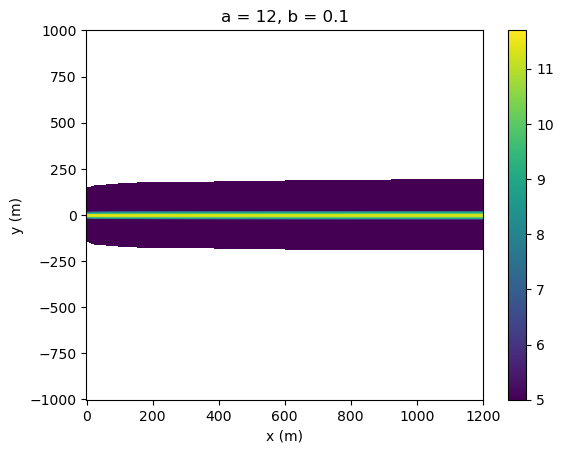

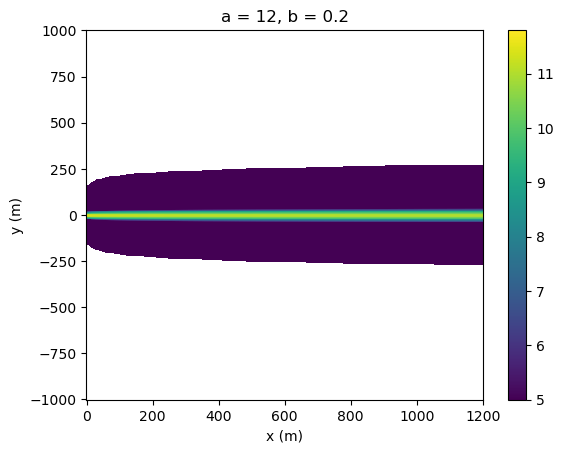

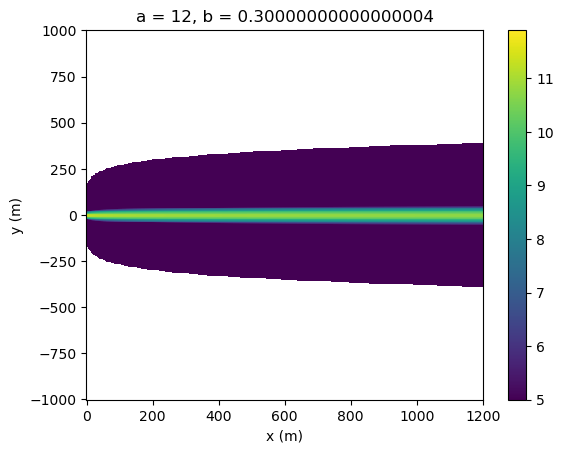

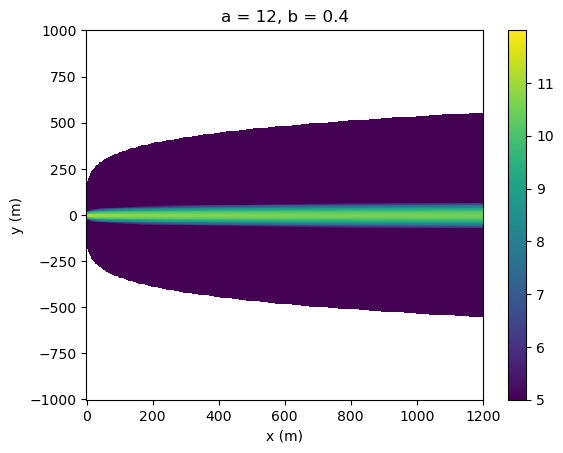

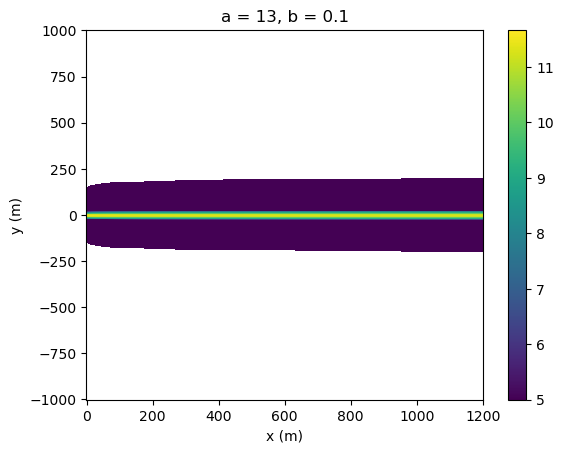

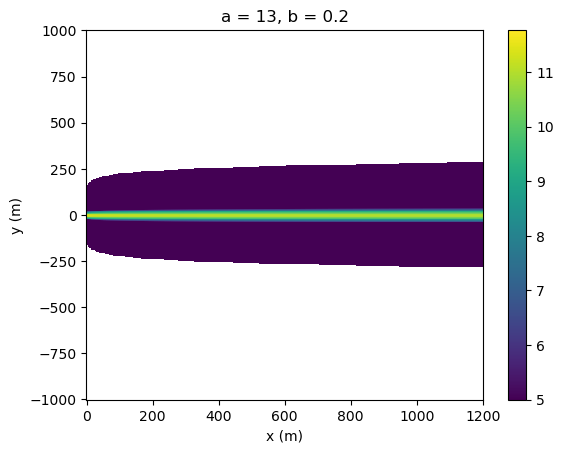

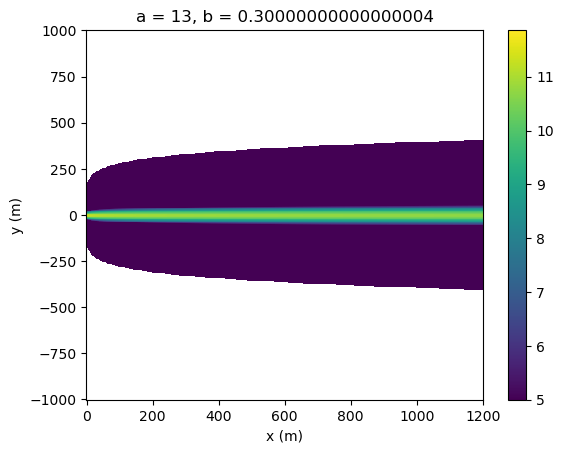

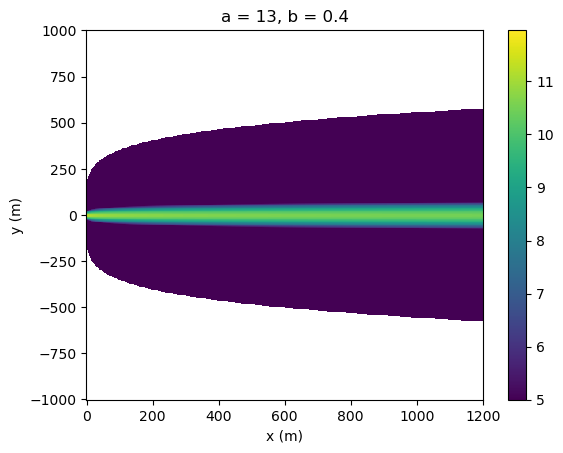

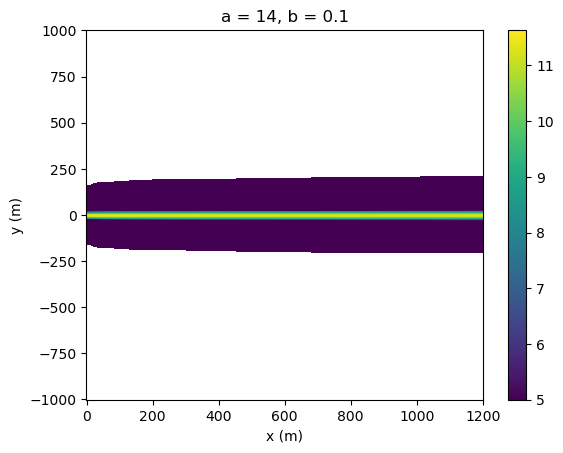

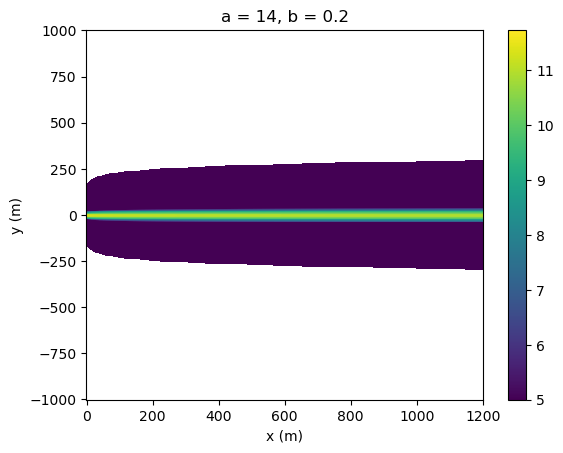

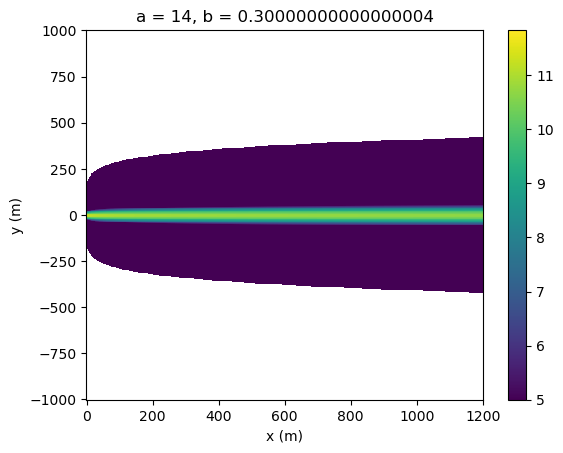

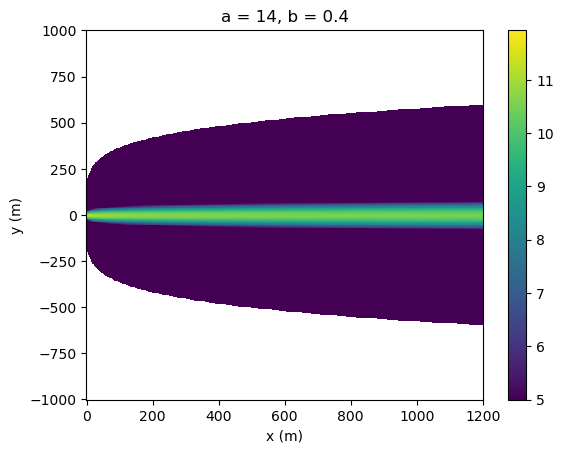

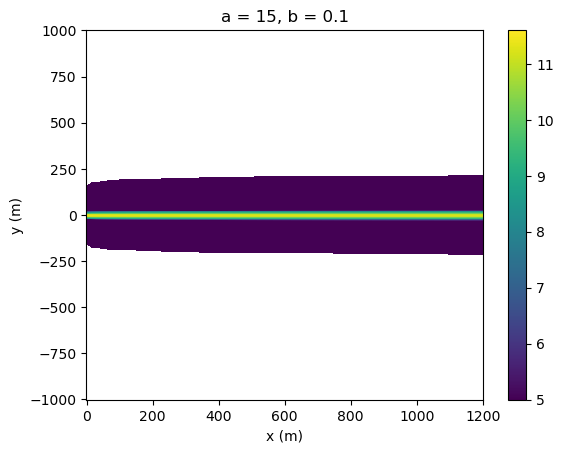

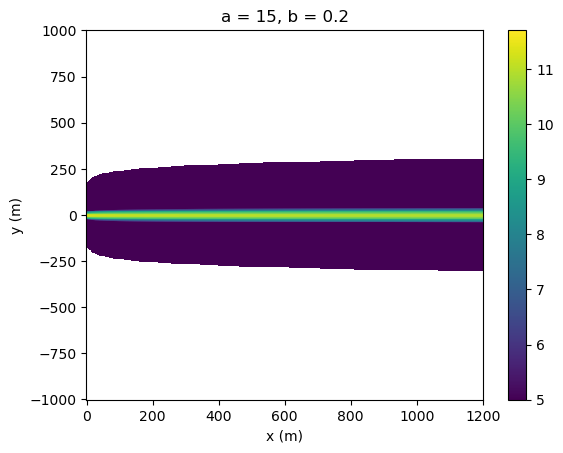

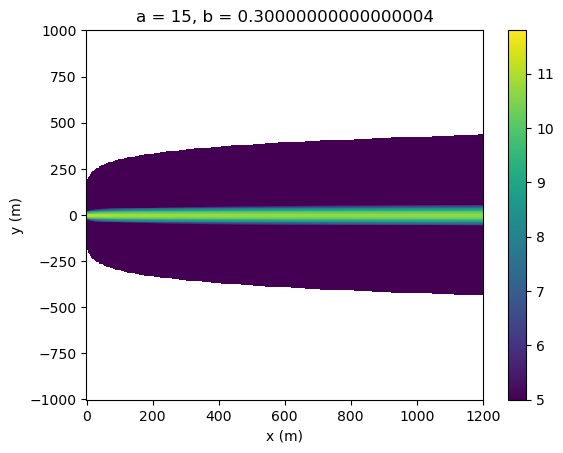

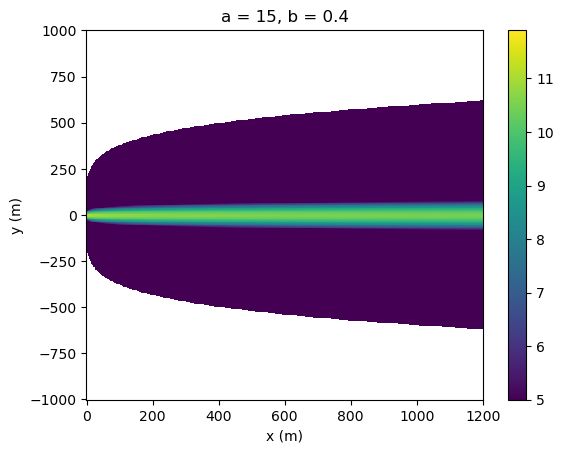

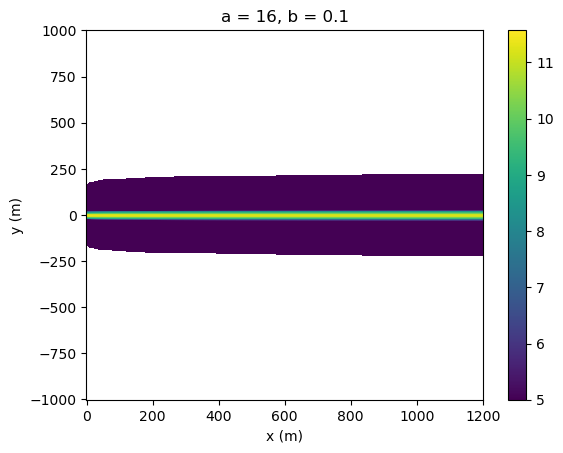

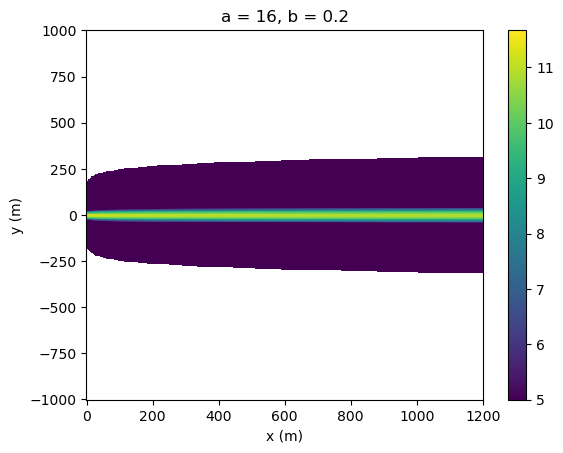

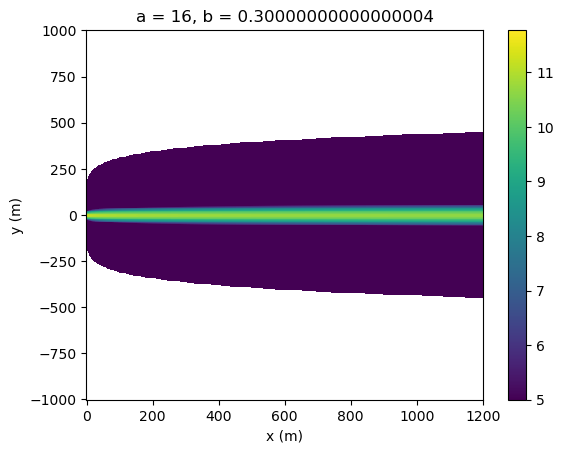

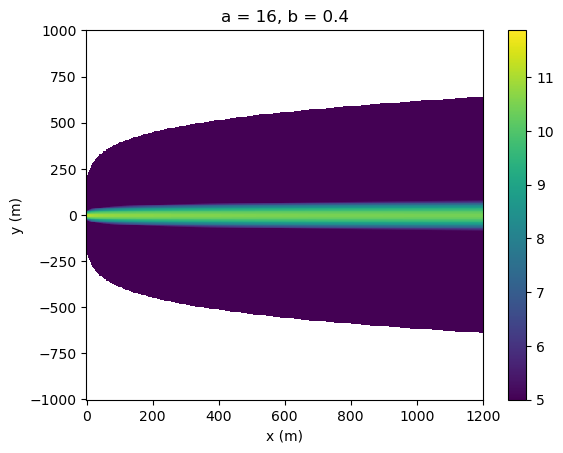

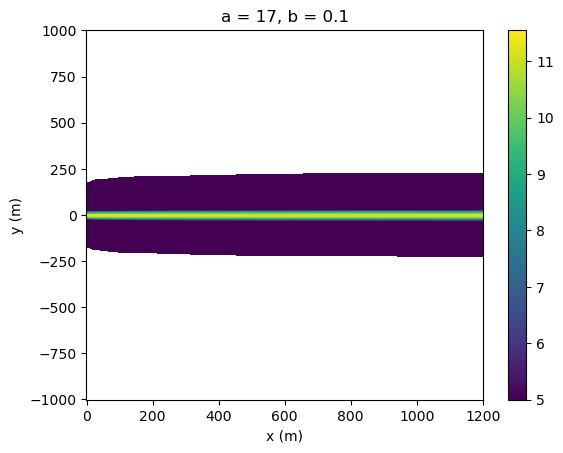

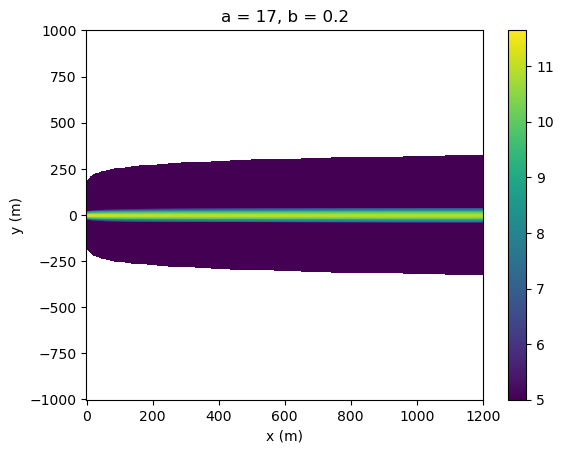

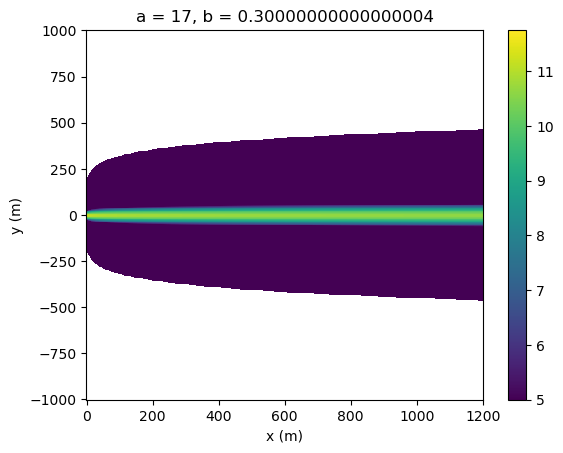

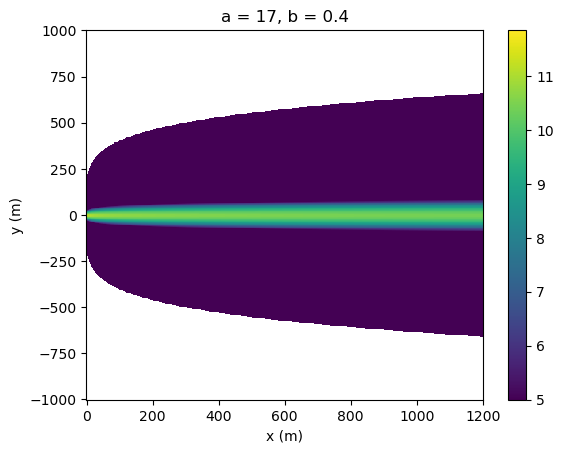

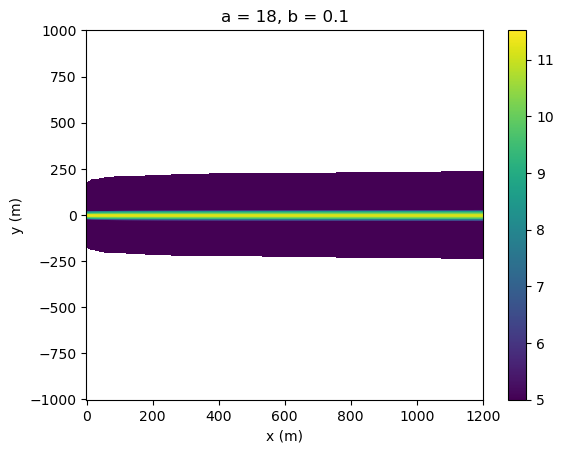

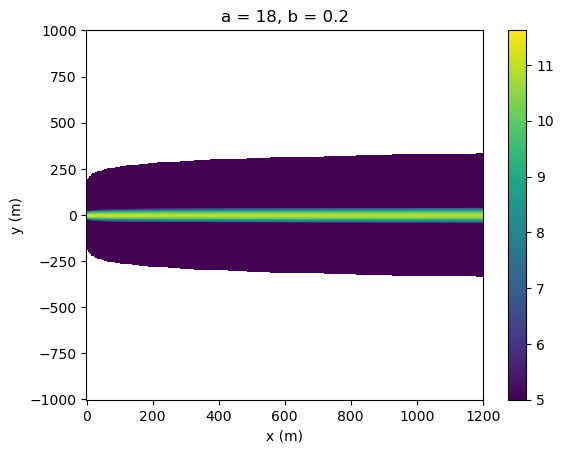

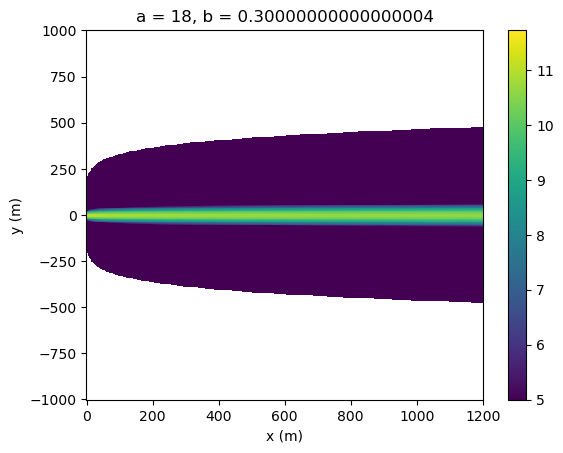

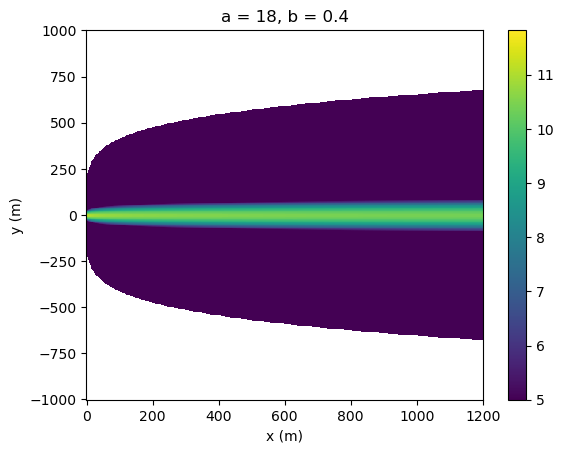

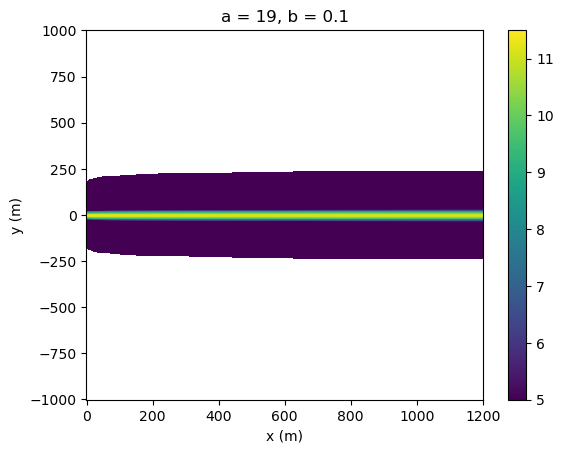

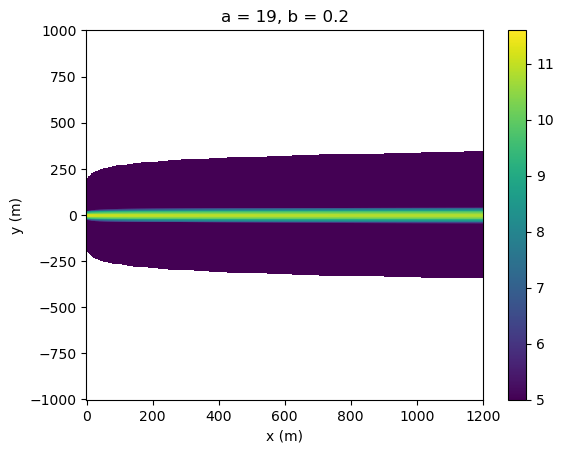

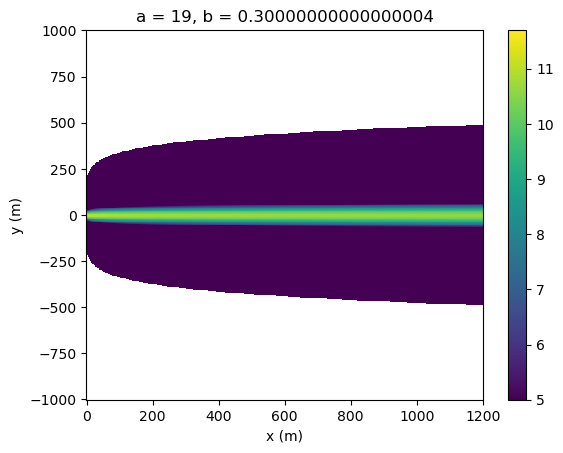

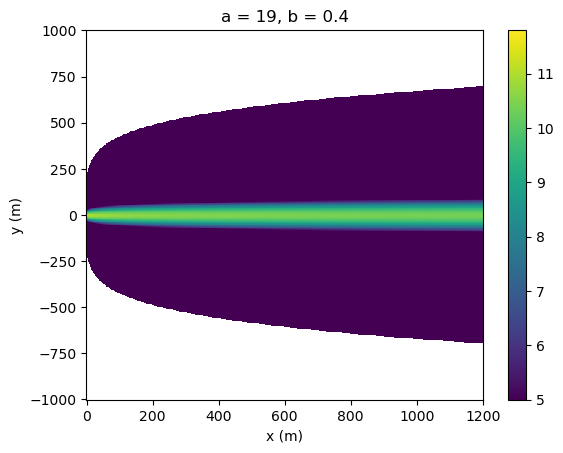

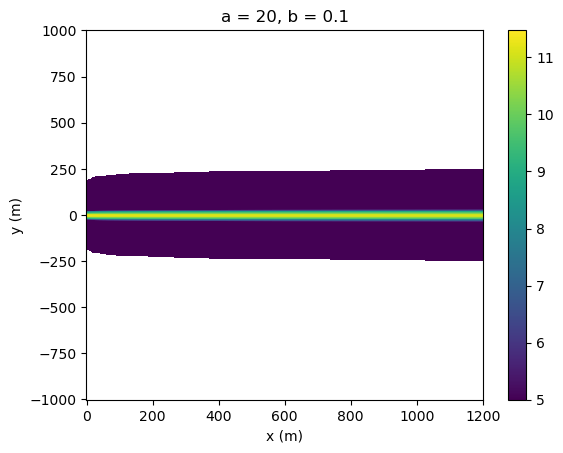

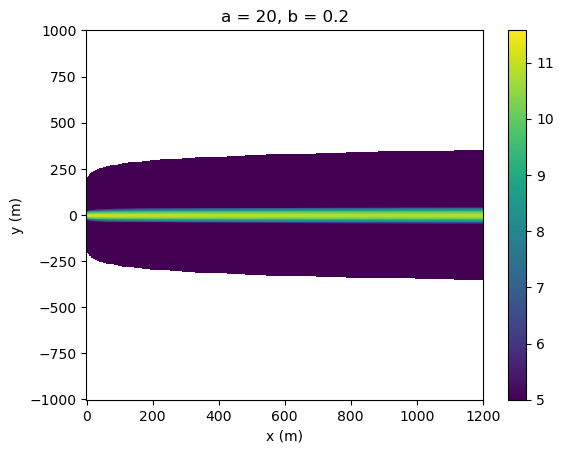

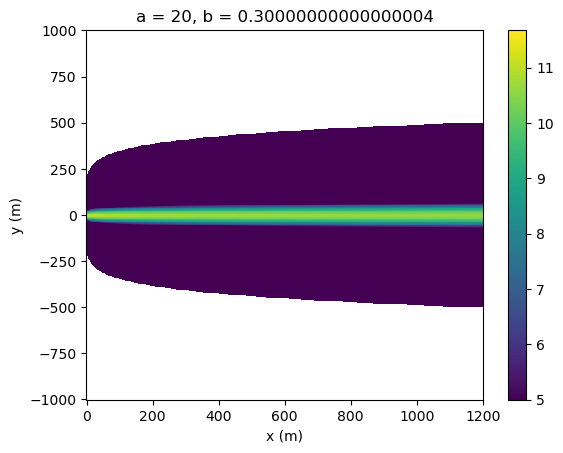

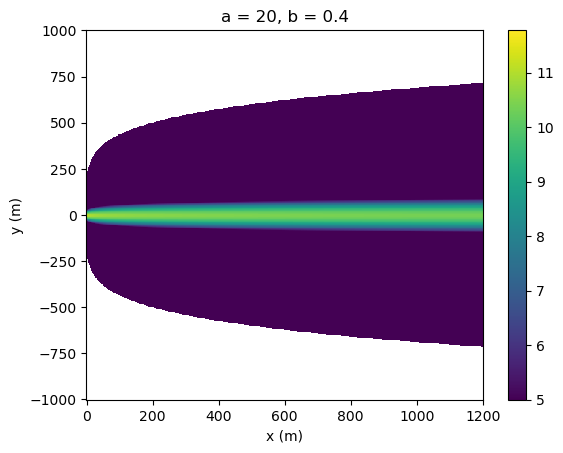

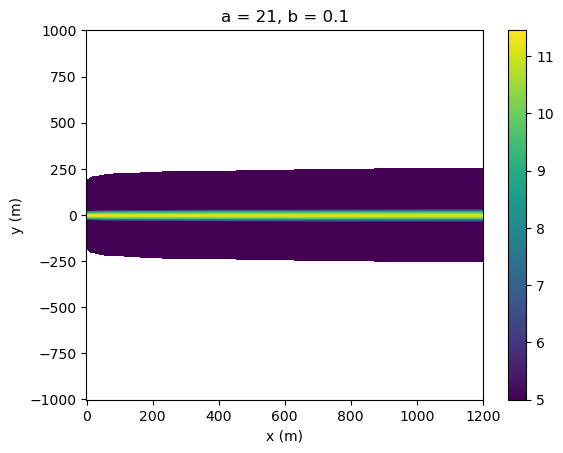

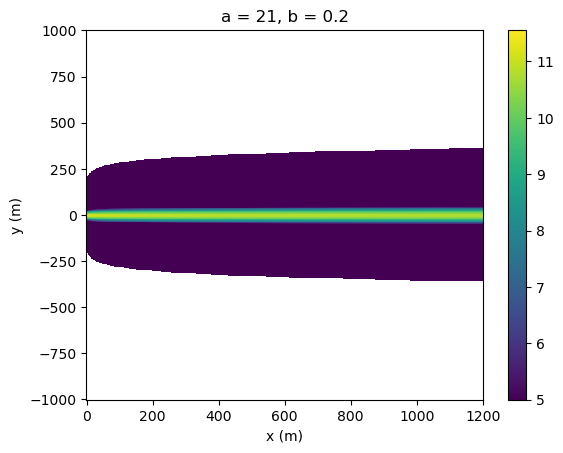

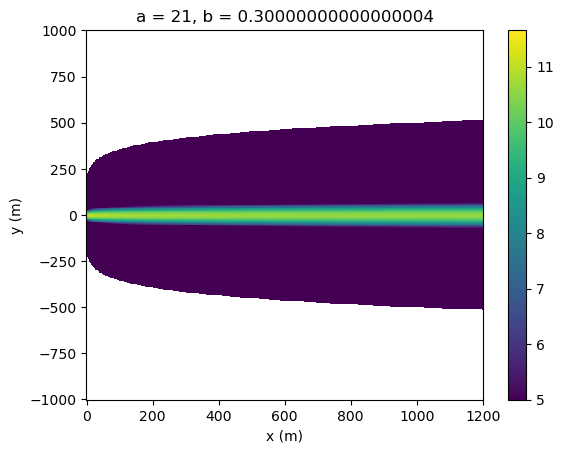

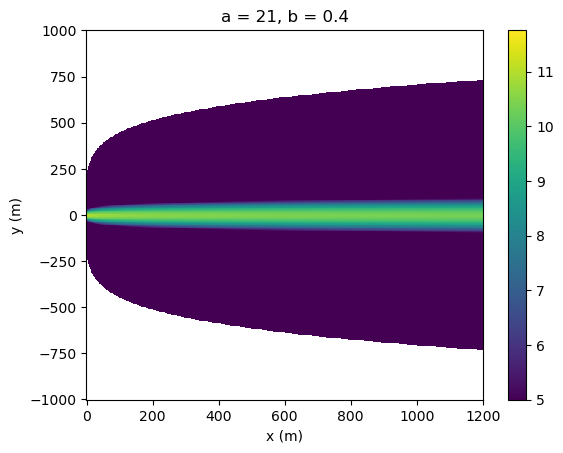

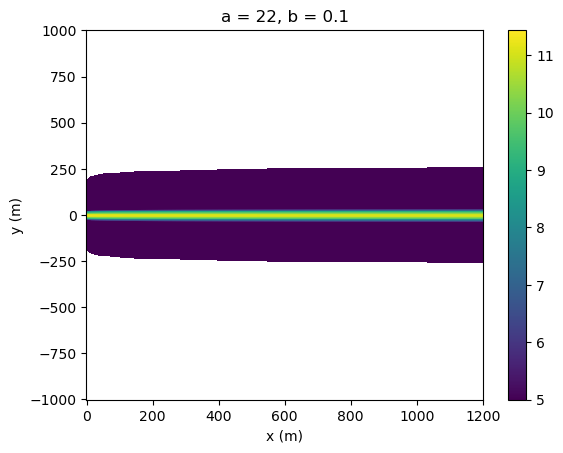

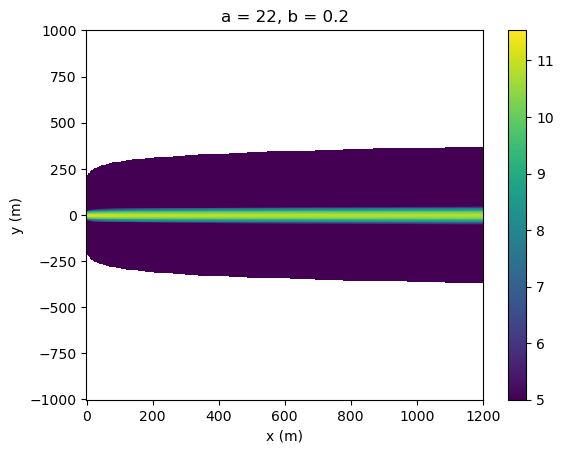

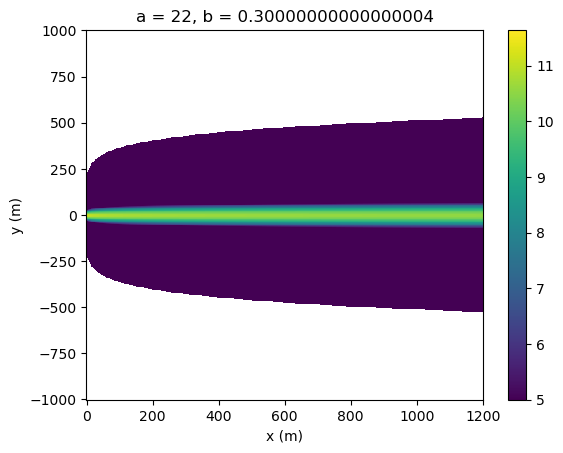

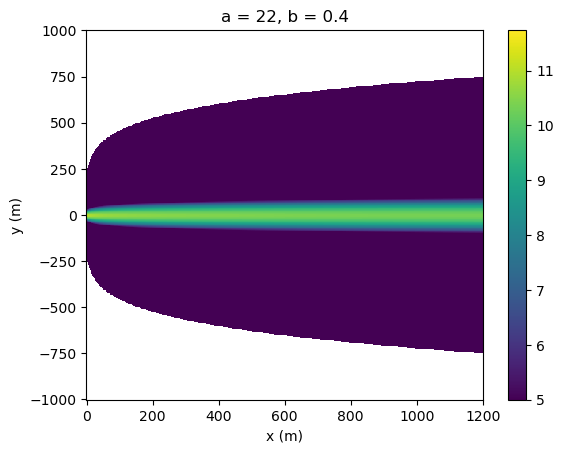

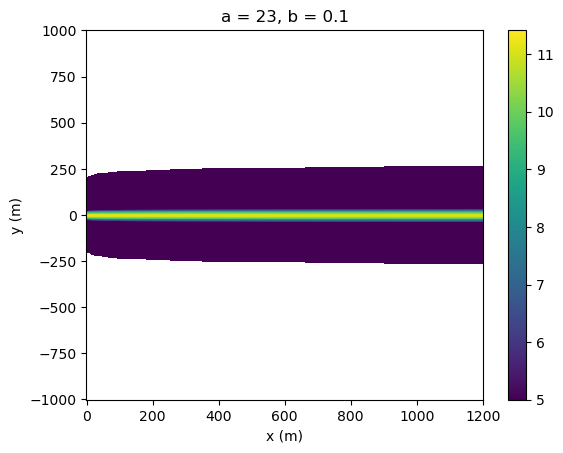

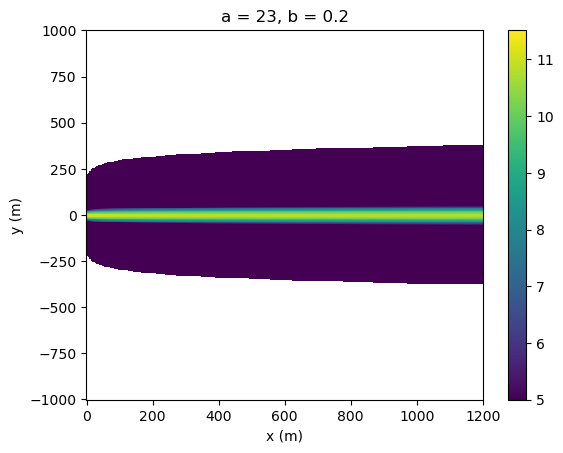

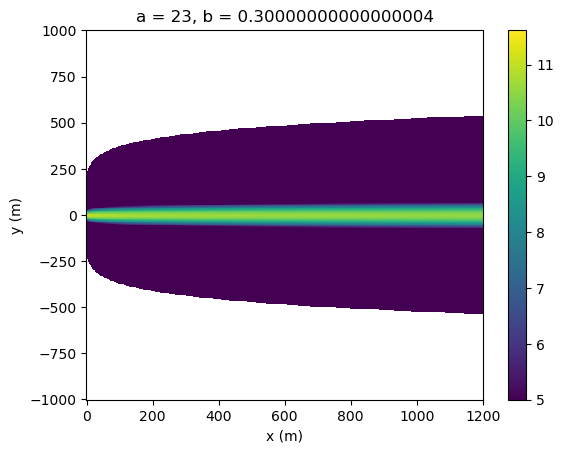

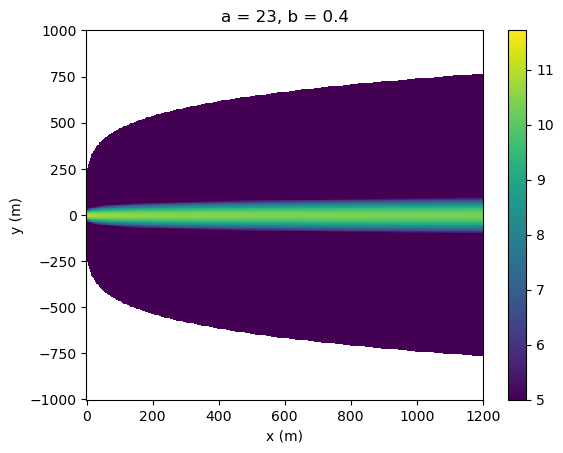

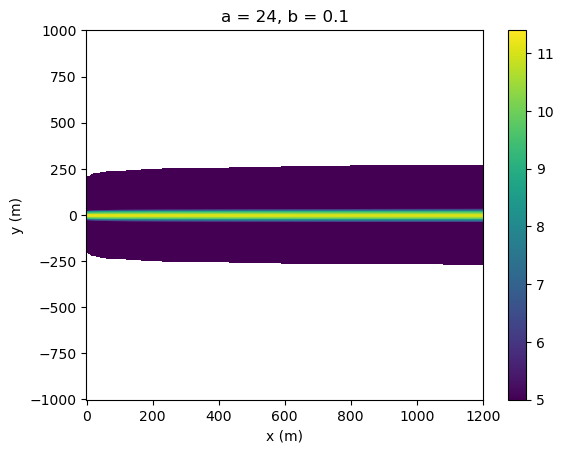

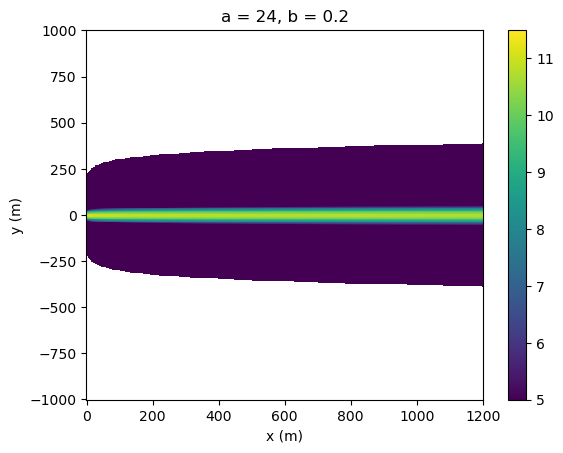

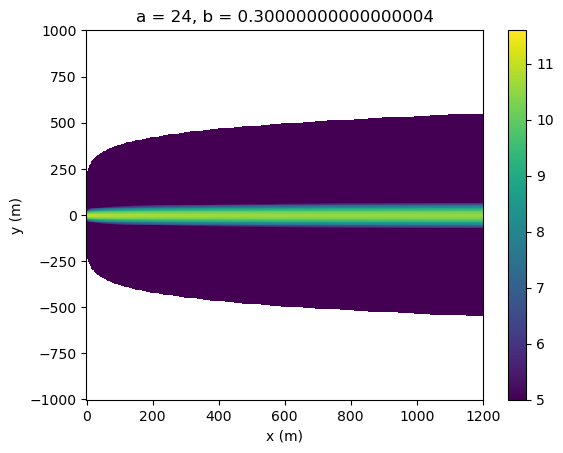

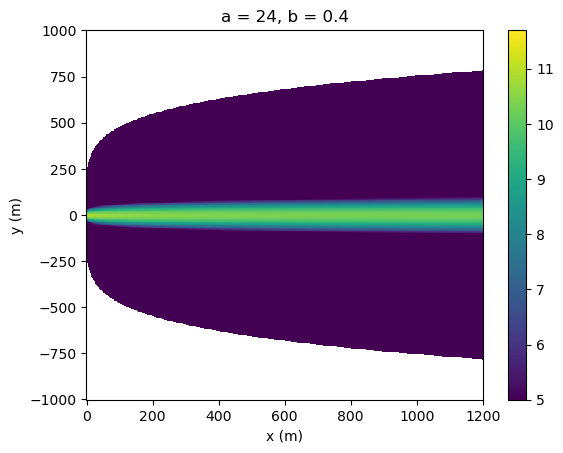

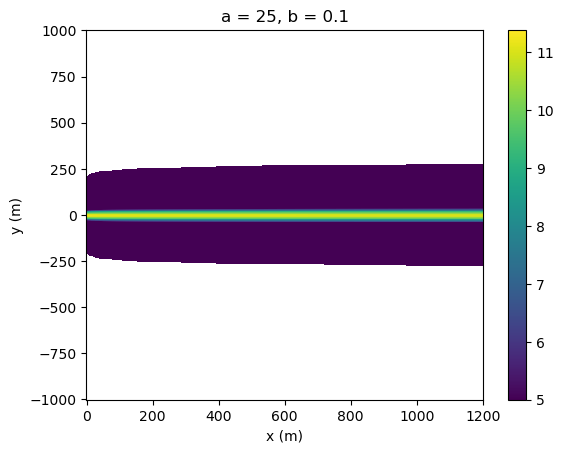

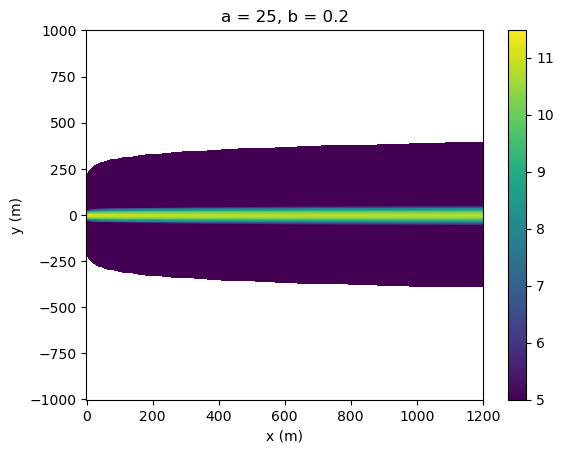

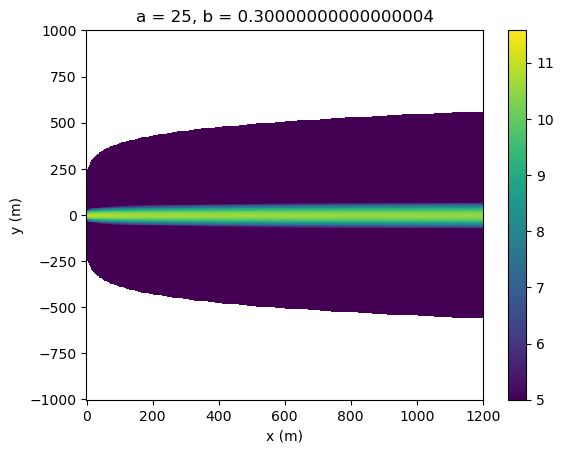

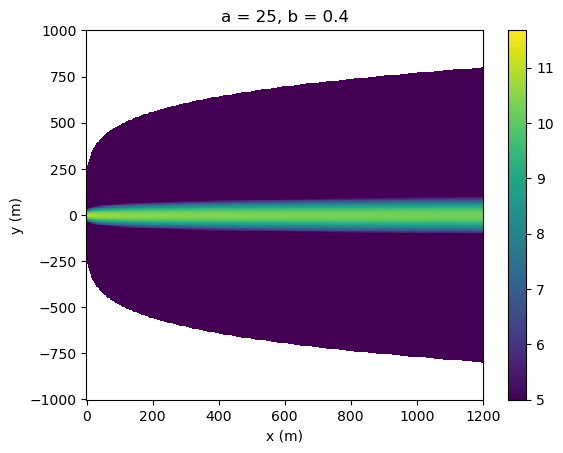

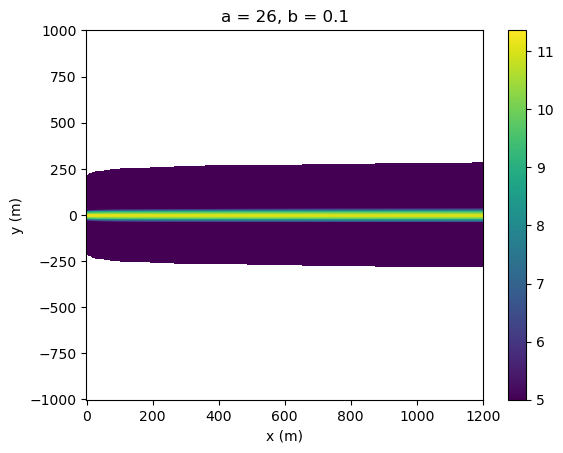

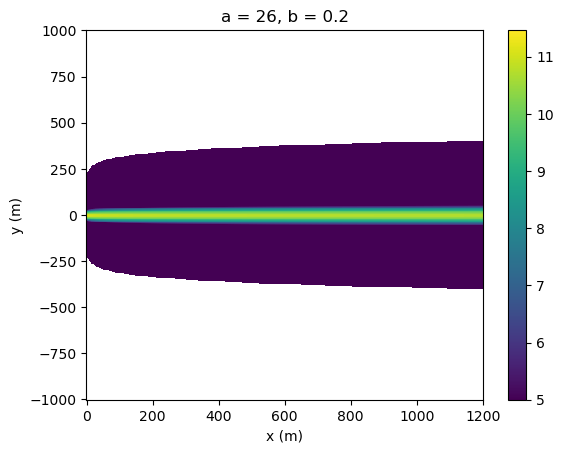

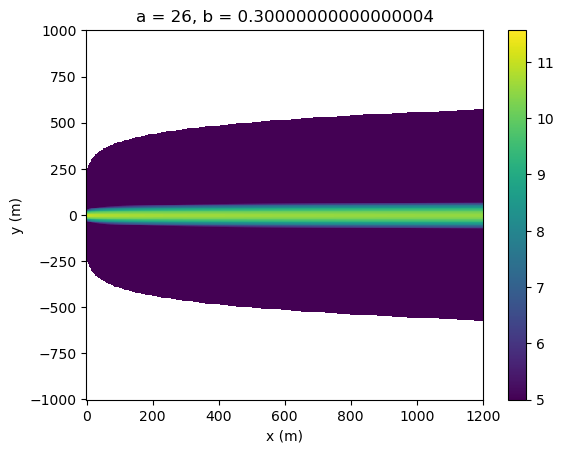

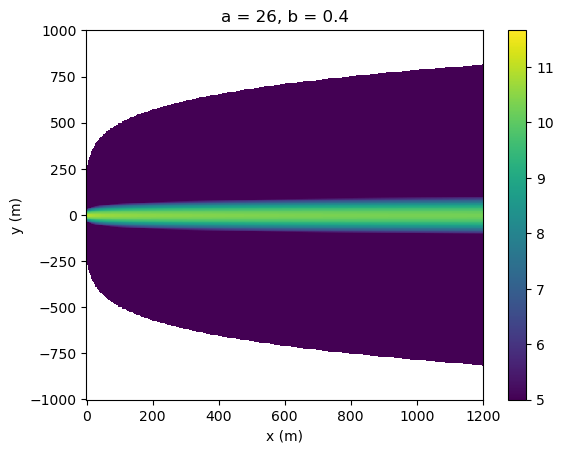

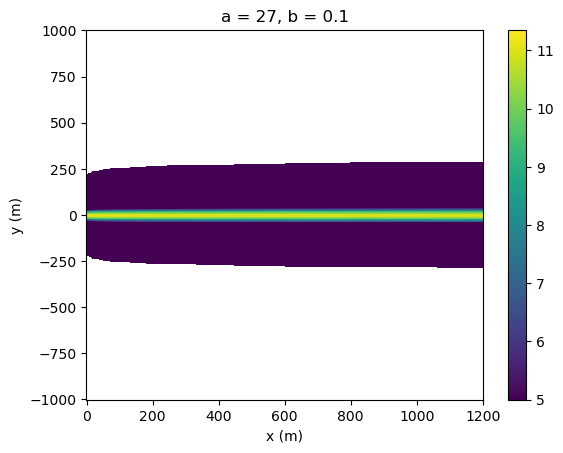

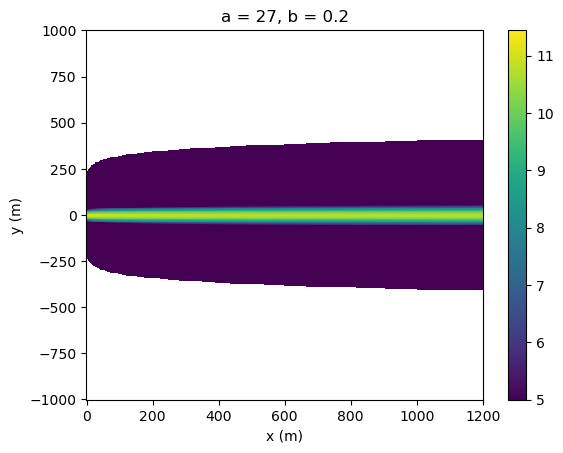

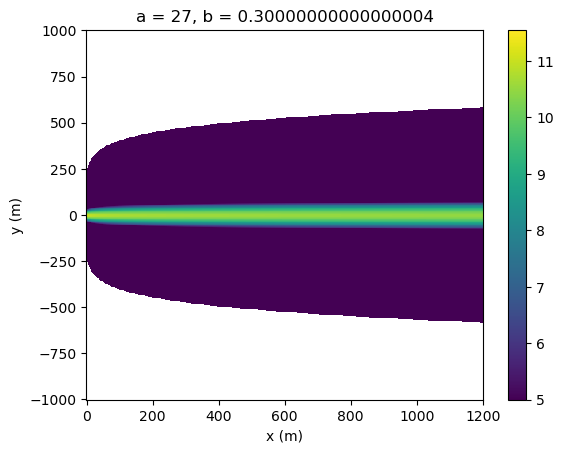

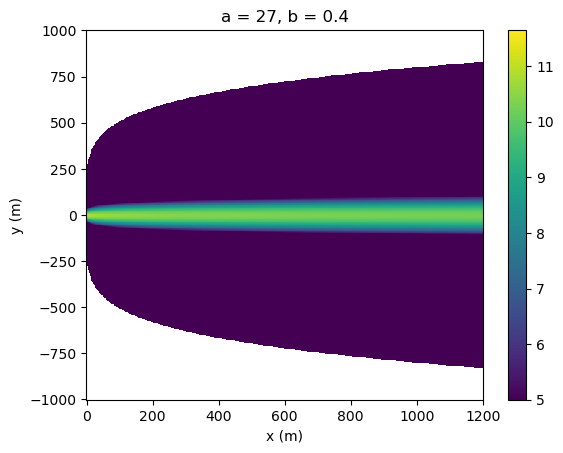

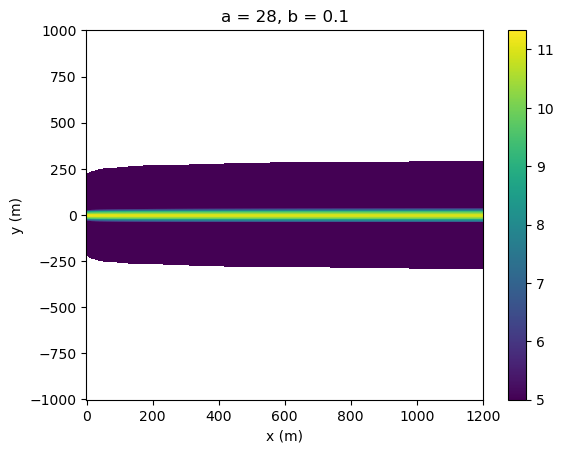

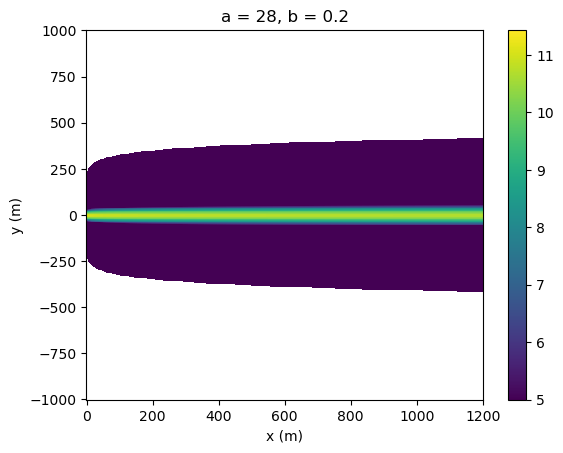

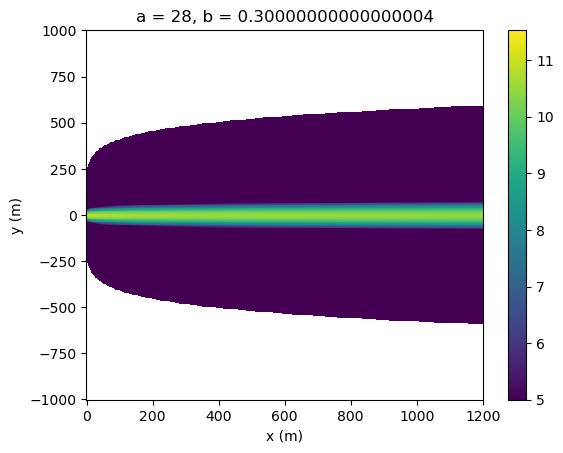

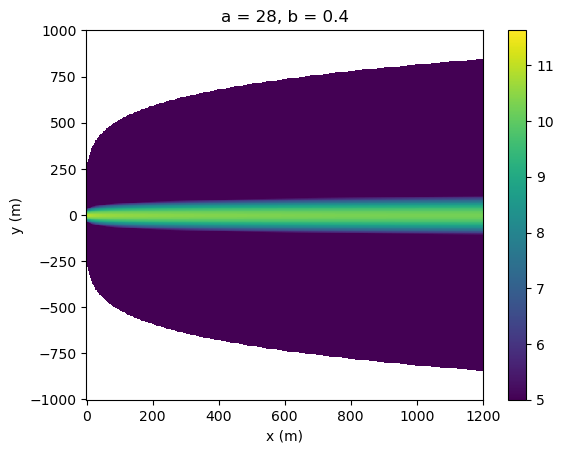

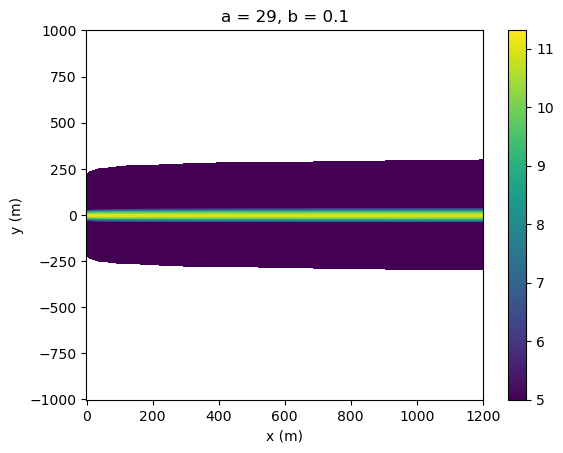

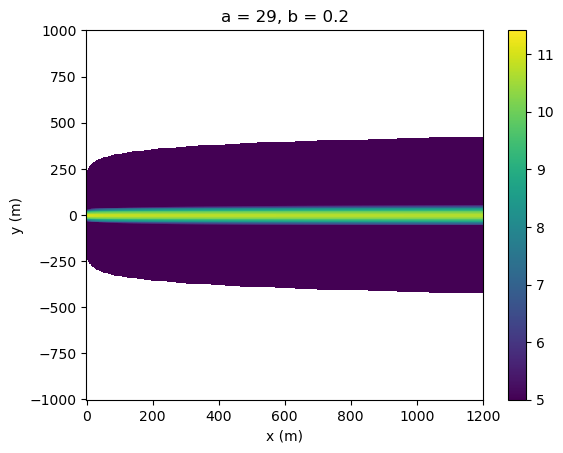

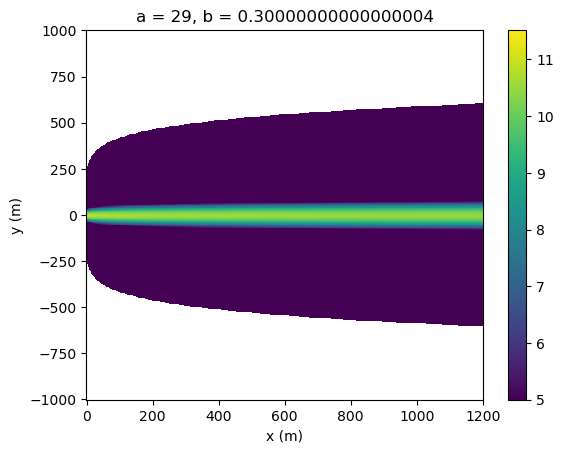

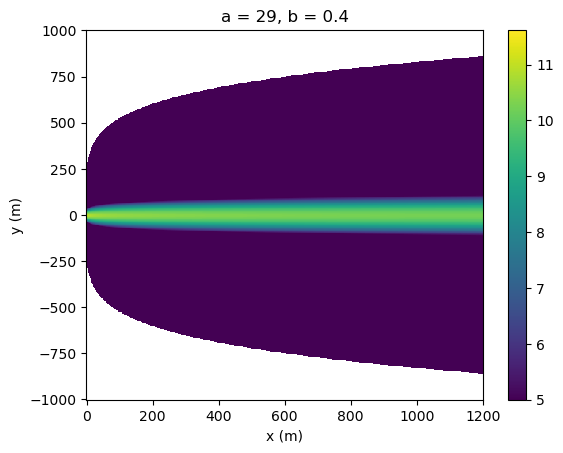

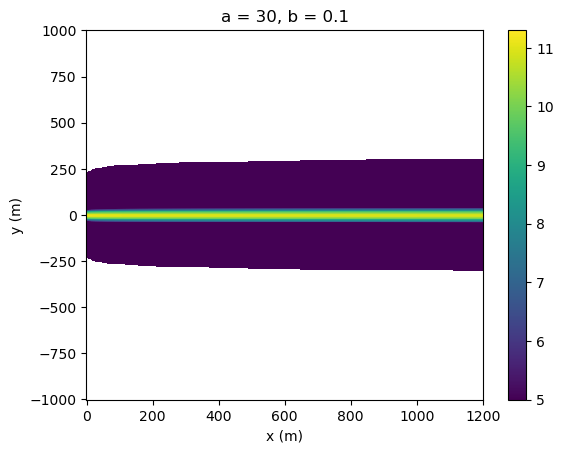

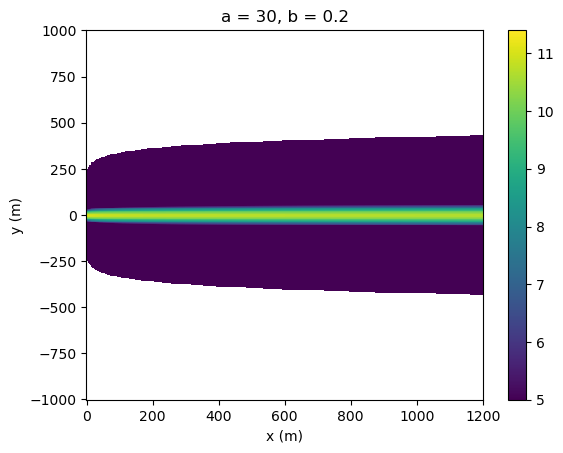

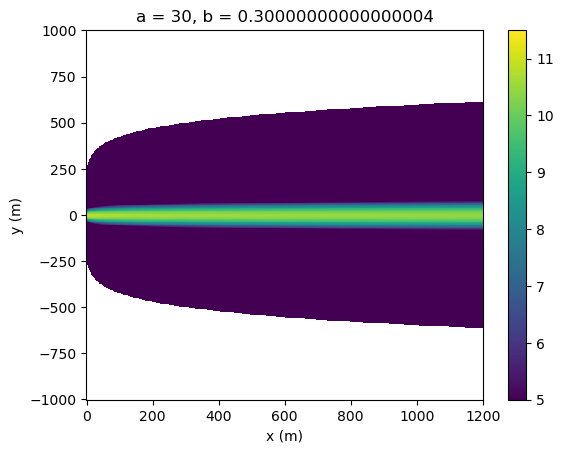

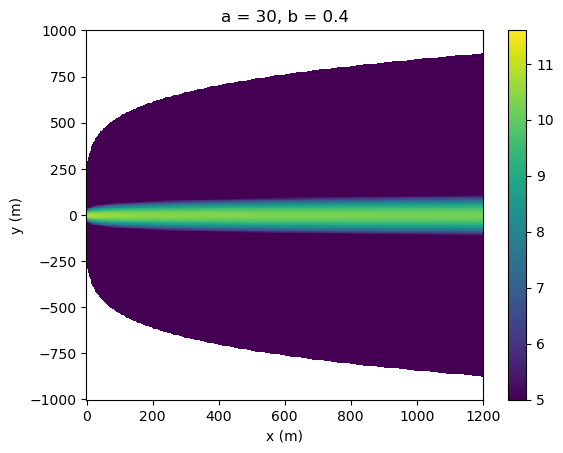

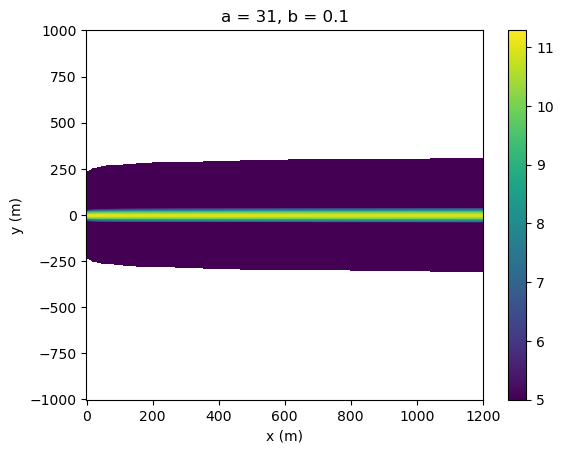

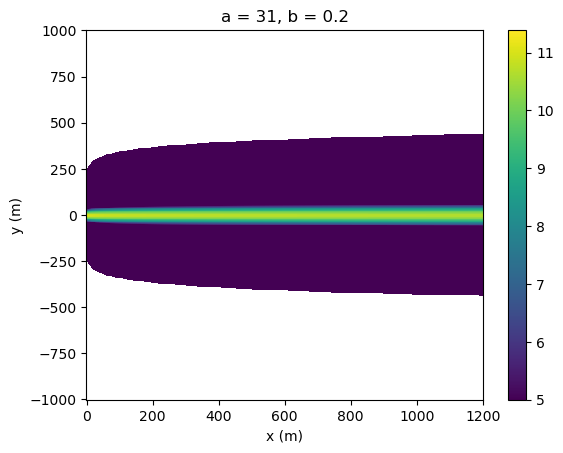

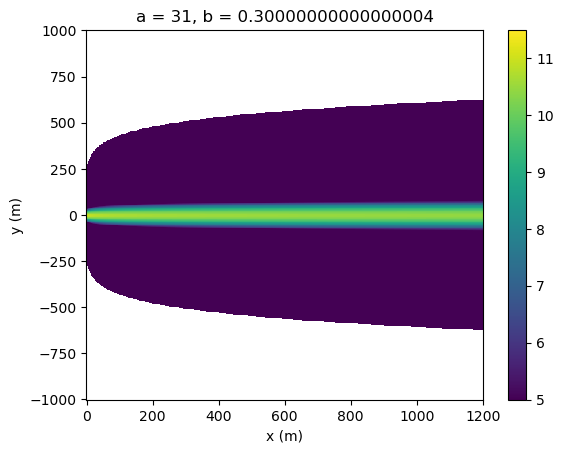

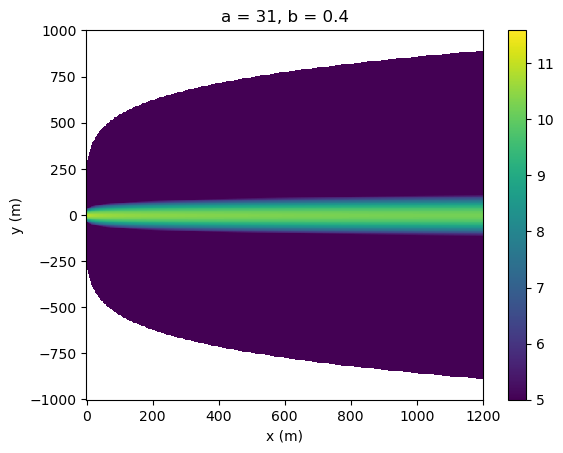

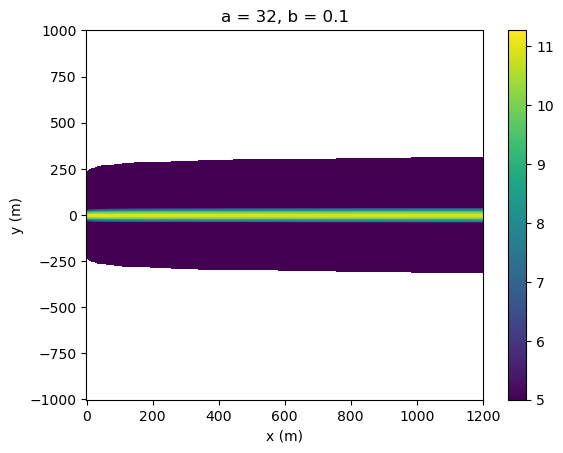

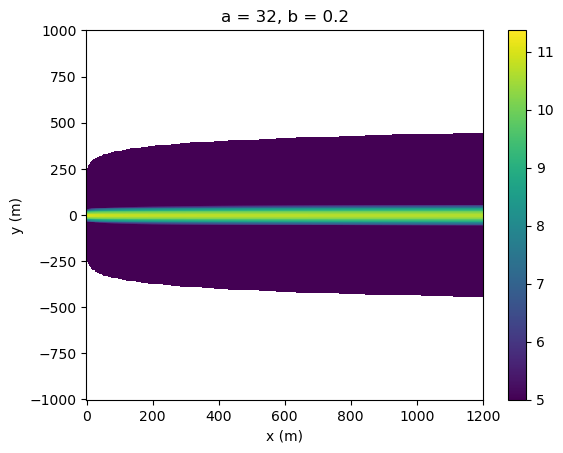

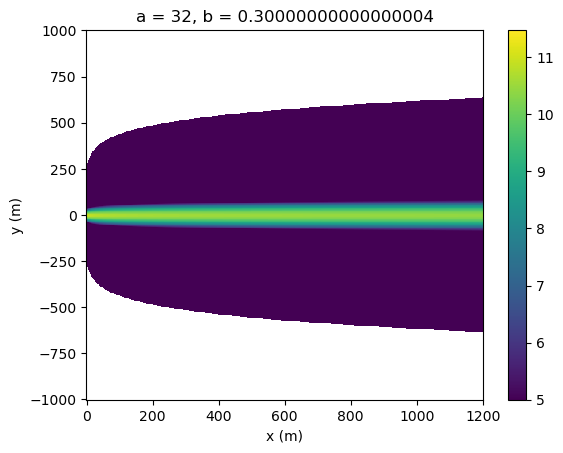

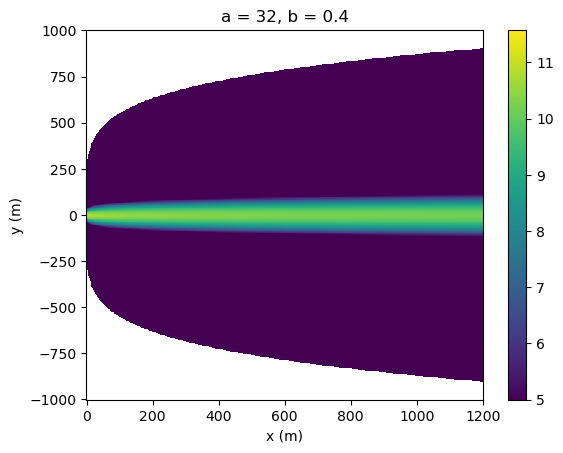

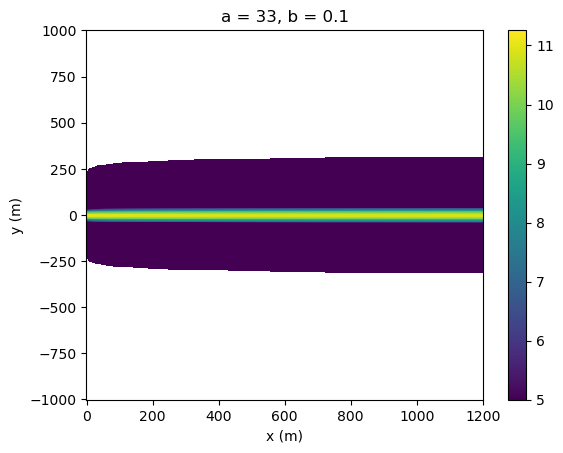

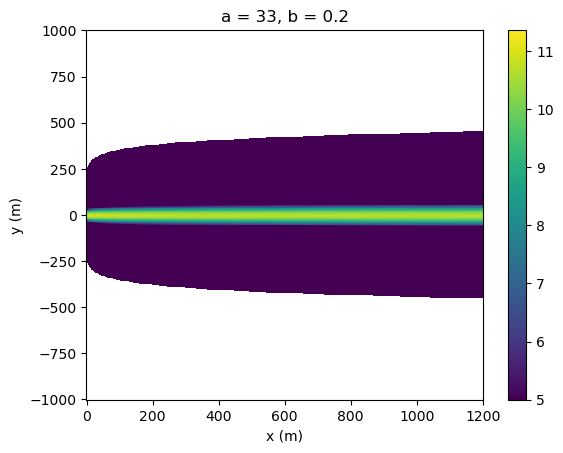

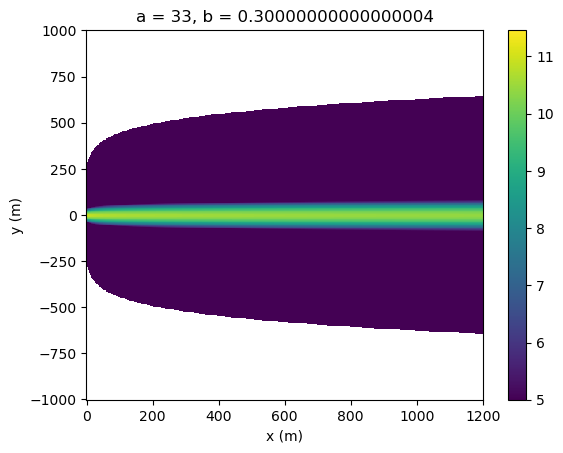

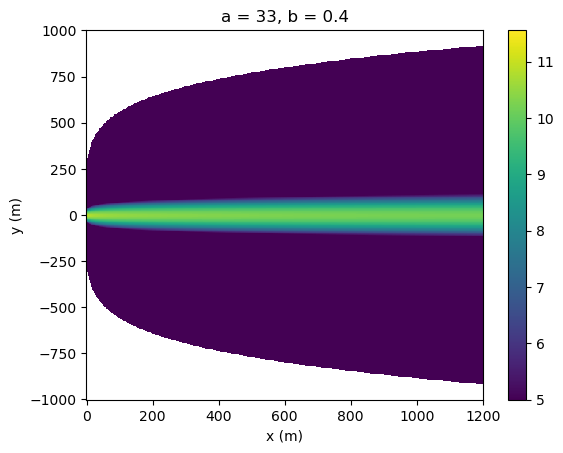

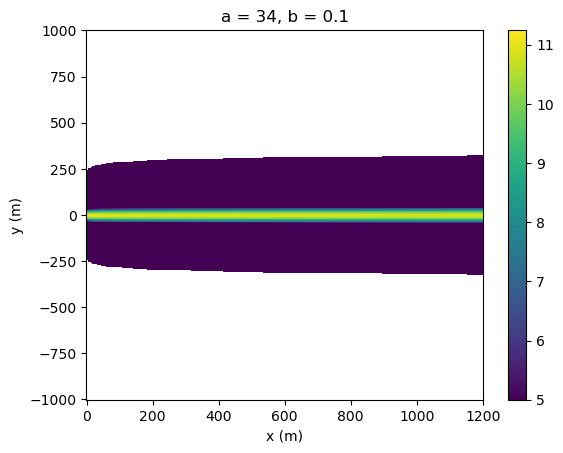

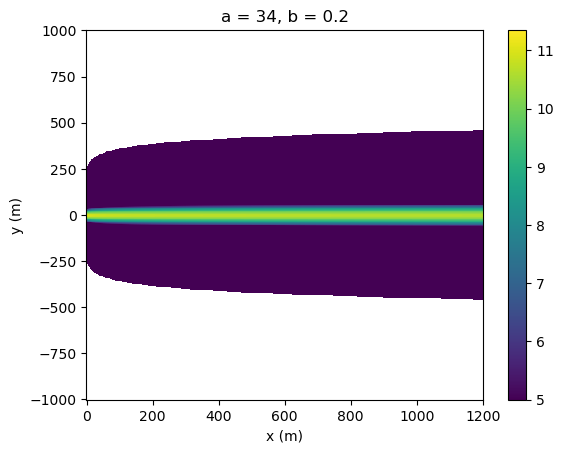

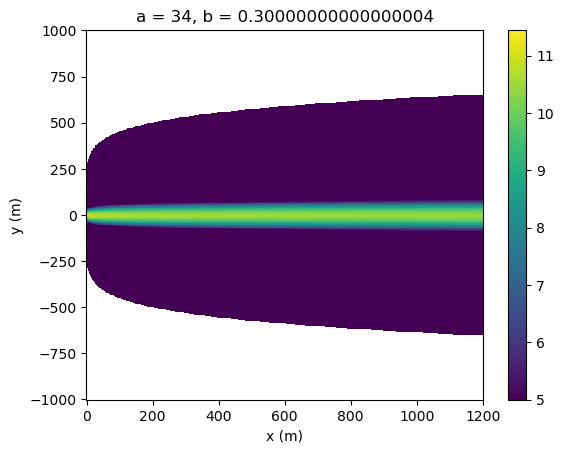

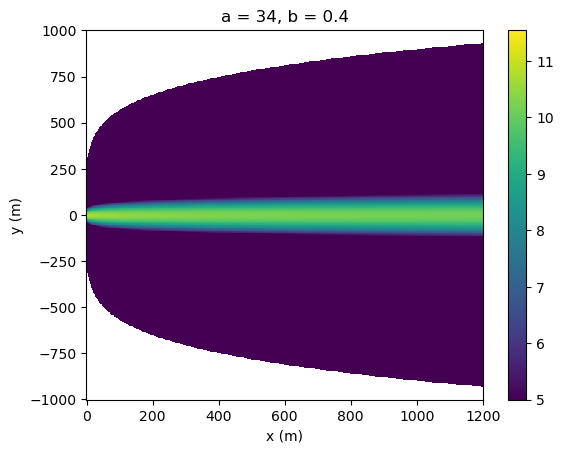

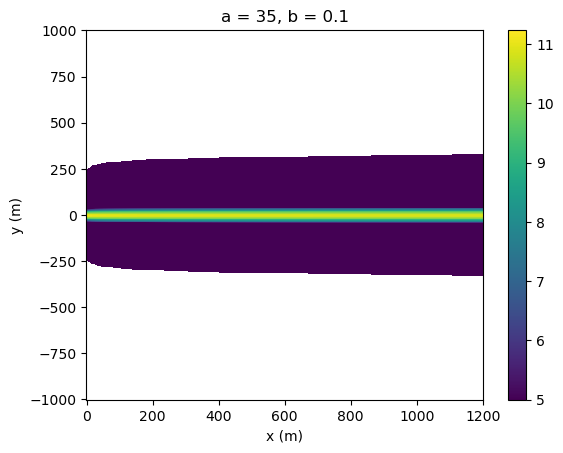

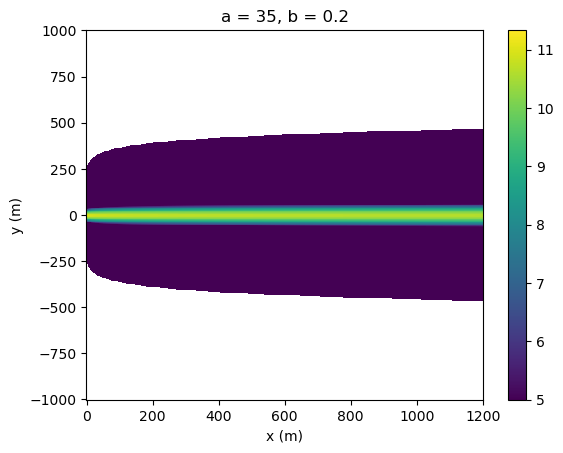

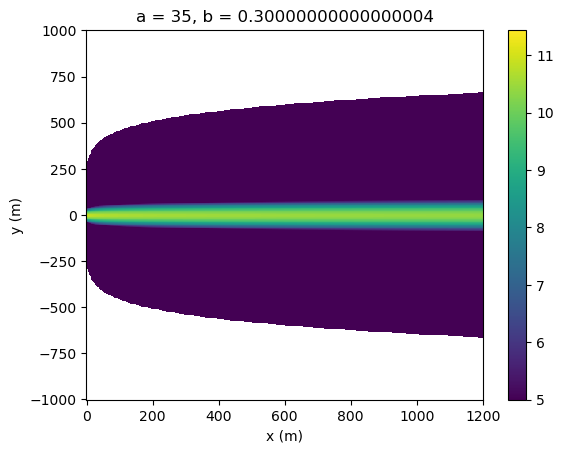

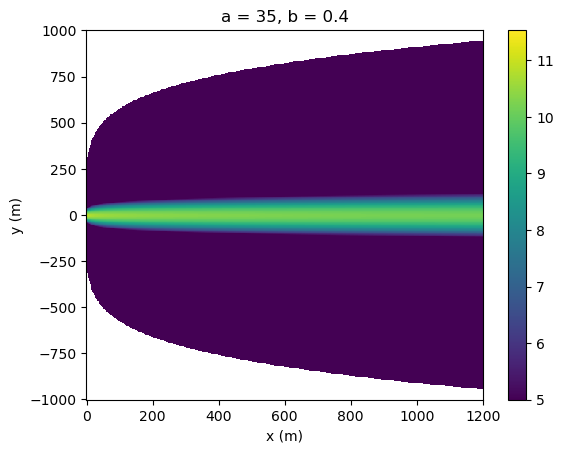

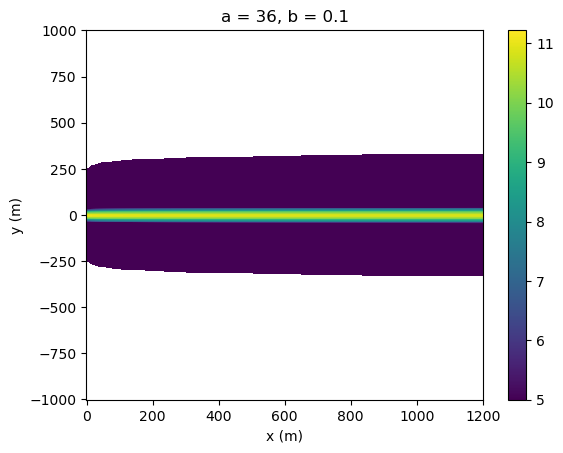

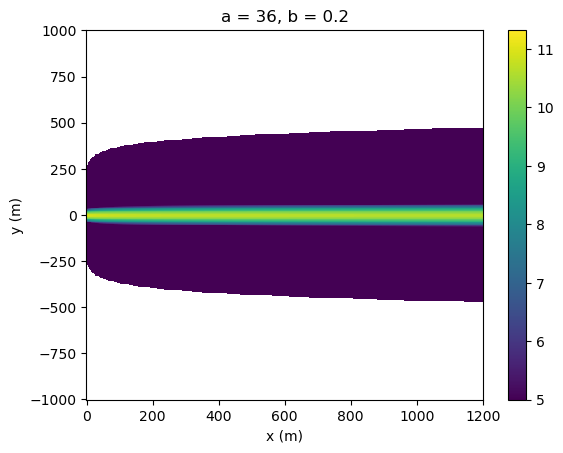

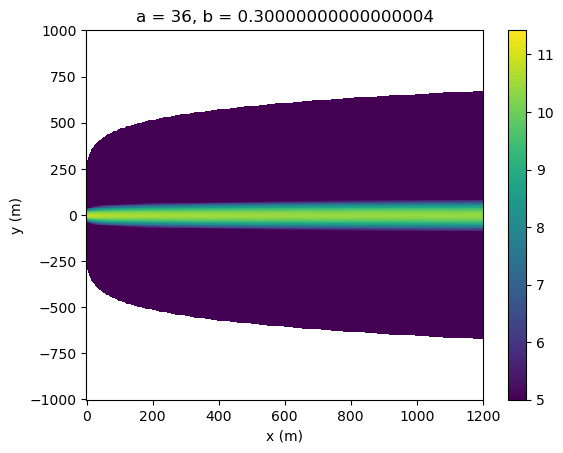

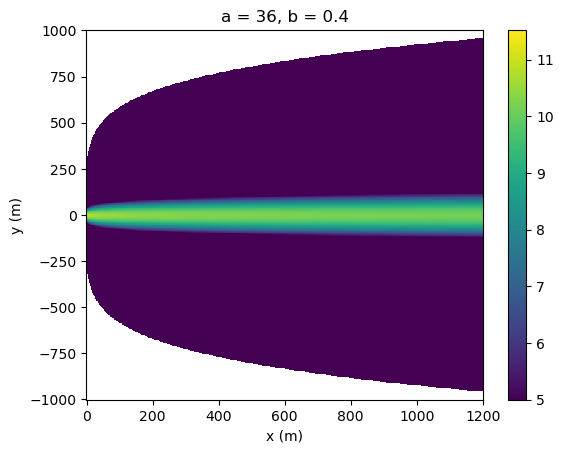

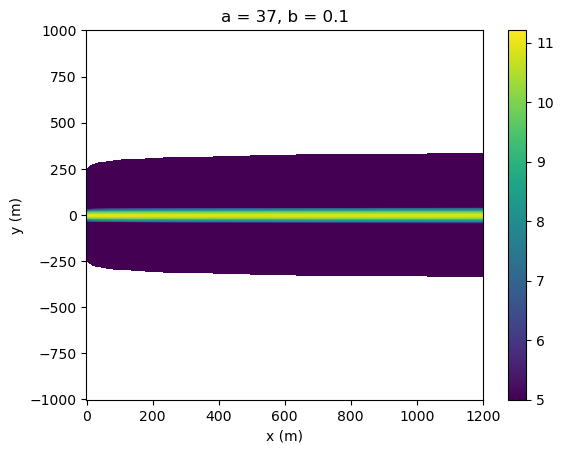

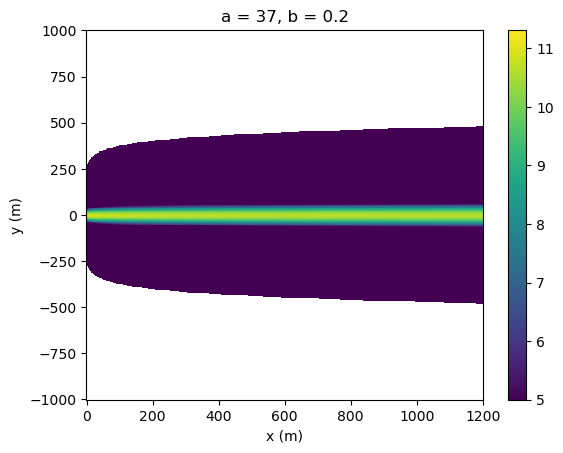

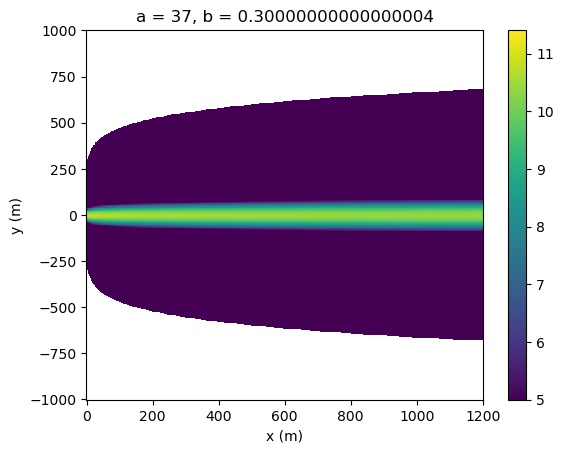

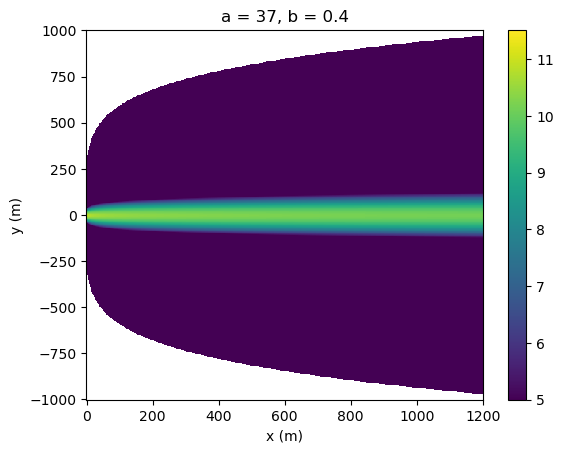

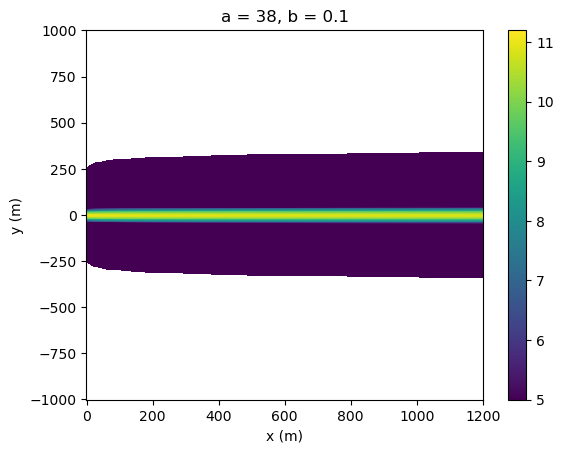

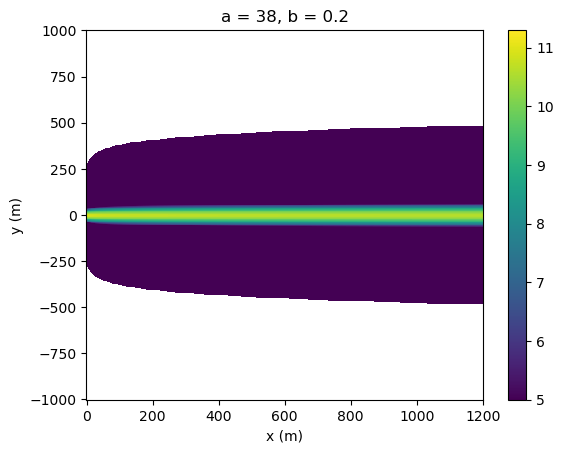

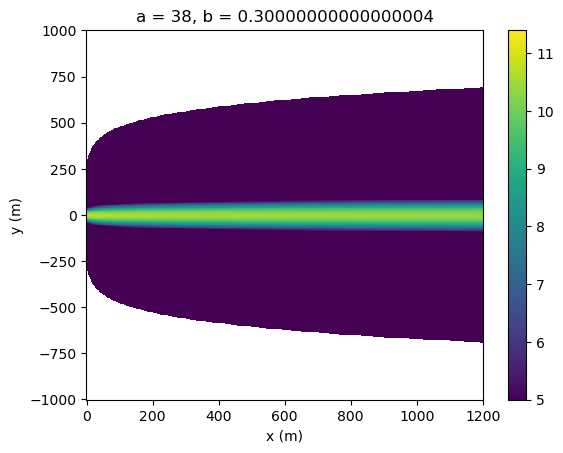

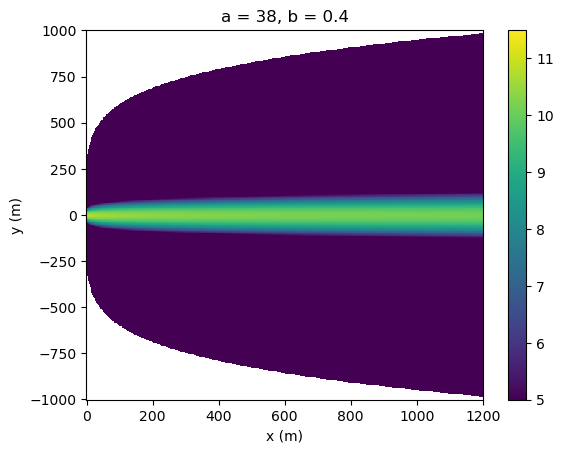

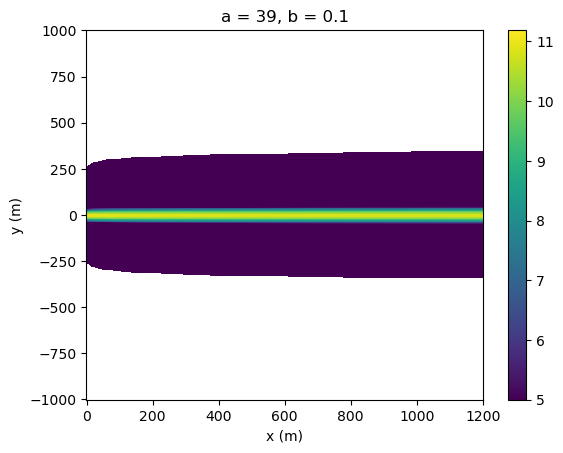

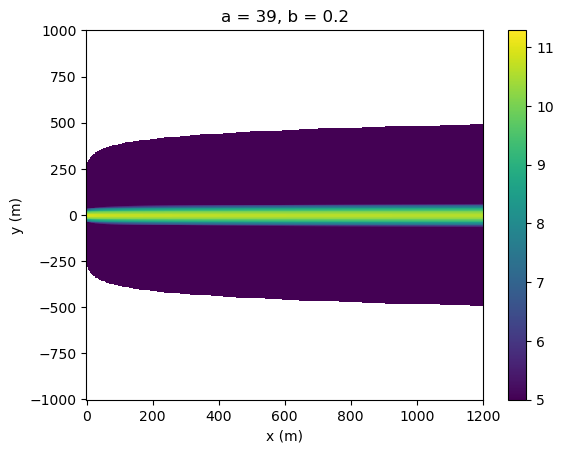

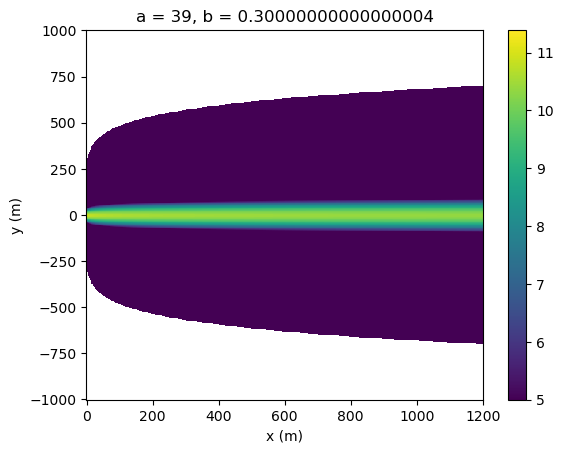

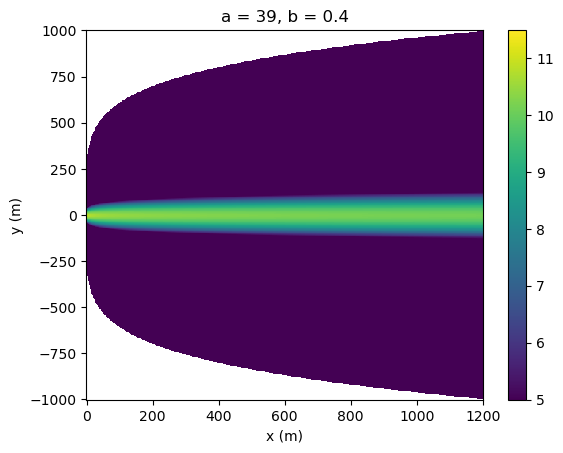

In [3]:
import numpy as np
from matplotlib import pyplot as plt

def model_func(a,b,Q, H, x, y, z):


    tmp = 2*a*x**b
    
    return Q / (tmp*np.pi)*(np.exp(-(y**2)/tmp))*(np.exp(-(z-H)**2/tmp)+np.exp(-(z+H)**2/tmp))


a = 1
b = 1
Q = 29977838439719.8

H = 10

x = np.linspace(0.1, 1200, 501)
y = np.linspace(-1000, 1000, 501)
X,Y = np.meshgrid(x, y)
Z = 10

del(x)
del(y)

grid = np.zeros((X.shape[0]**2,3))
grid[:,0] = X.reshape(X.shape[0]**2)
grid[:,1] = Y.reshape(Y.shape[0]**2)
grid[:,2] = np.ones(X.shape[0]**2)*Z


for a in np.arange(10,40,1):
    for b in np.arange(0.1,0.4,0.1):

        C = model_func(a,b,Q,H, X,Y,Z)

        plt.pcolor(X, Y, np.log10(C), shading = 'auto',vmin=5)
        plt.colorbar()
        # plt.scatter(maximums[:,0], maximums[:,1], s=maximums[:,3]/1e8)
        plt.title('a = ' + str(a) + ', b = ' + str(b))
        plt.xlabel('x (m)')
        plt.ylabel('y (m)')
        plt.show()